In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA  
from scipy.stats.distributions import chi2
from statsmodels.tsa.stattools import adfuller

In [2]:
file='Index2018.csv'
data=pd.read_csv(file)
print(data.dtypes,'\n\nShape ->',data.shape)
data.head()

date       object
spx       float64
dax       float64
ftse      float64
nikkei    float64
dtype: object 

Shape -> (6269, 5)


,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


## <span style="color: yellow;">Proprocessing</span>


In [3]:
# No missings observed
data.isna().sum()

date      0
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [4]:
# Setting date as index for the data
# changing column type to index64
data['date']=pd.to_datetime(data['date'],dayfirst=True)
# Setting to index
data.set_index('date',inplace=True)

In [5]:
# Changing frequency to business days and interval to 2010-Now
mask=data.index.year>=2010
data=data[mask]
data=data.asfreq('b')

In [6]:
# 5 missings observed in each col
data.isna().sum()

spx       5
dax       5
ftse      5
nikkei    5
dtype: int64

In [7]:
# Filling na with first_fill
data.fillna(method='ffill',inplace=True)
data.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

## <span style="color: yellow;">ACF & PACF</span>


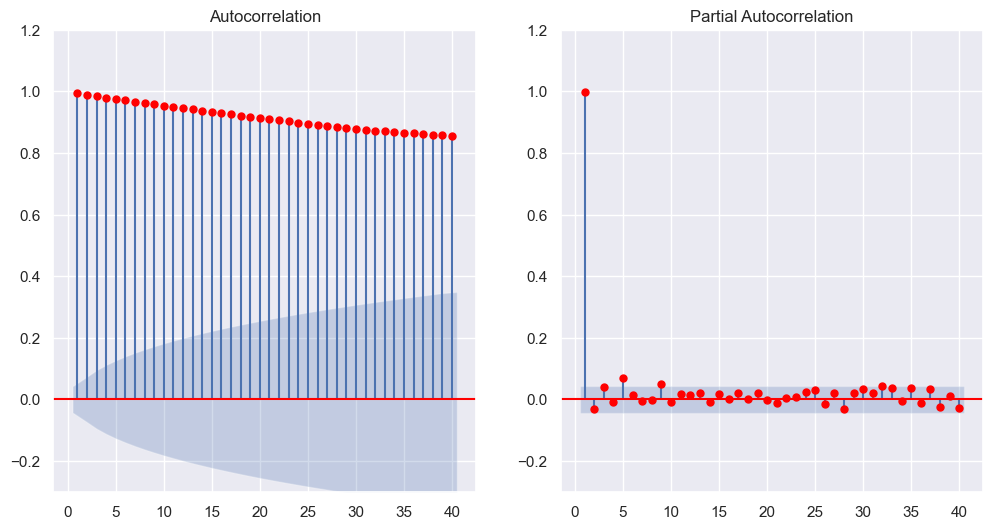

In [8]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
plot_acf(data['ftse'],ax=ax[0],color='red',zero=False,lags=40)
ax[0].set_ylim(-0.3,1.2)
plot_pacf(data['ftse'],ax=ax[1],color='red',zero=False,lags=40,method=('ols'))
ax[1].set_ylim(-0.3,1.2)
plt.show()

## <span style="color: yellow;">Fitting The Model</span>


#### <span style="color: green;">LogLikelihood Ratio LLR</span>


In [9]:
def llr(model1,model2,df=1):
    l1=model1.llf
    l2=model2.llf
    lr=2*(l2-l1)
    p=chi2.sf(lr,df).round(3)
    return p

#### <span style="color: green;">AR(1) model</span>


In [10]:
ar=ARIMA(data['ftse'],order=(1,0,0)).fit()
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 2106
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -11485.860
Date:                Mon, 11 Mar 2024   AIC                          22977.720
Time:                        17:36:18   BIC                          22994.678
Sample:                    01-04-2010   HQIC                         22983.930
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6326.4199    383.375     16.502      0.000    5575.018    7077.822
ar.L1          0.9971      0.002    515.997      0.000       0.993       1.001
sigma2      3188.4595     70.648     45.131      0.000    3049.991    3326.928
===================================================================================
Ljung-Box (L1) (Q):                   2.16   Jarque-Bera (JB):               335.78
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.21
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### <span style="color: green;">AR(+) model</span>


In [11]:
models=[]
start=1
max_order=9
for i in range(start,max_order+1):
    ar_model=ARIMA(data['ftse'],order=(i,0,0)).fit()
    models.append(ar_model)
for j in range(len(models)-1):
    print('LLR for model {} and model {} is: {}'.format(j+1,j+2,llr(models[j],models[j+1])))

LLR for model 1 and model 2 is: 0.134
LLR for model 2 and model 3 is: 0.07
LLR for model 3 and model 4 is: 0.673
LLR for model 4 and model 5 is: 0.002
LLR for model 5 and model 6 is: 0.535
LLR for model 6 and model 7 is: 0.766
LLR for model 7 and model 8 is: 1.0
LLR for model 8 and model 9 is: 0.027


In [12]:
# Checking llr for models_order-5 and order-1
llr(models[0],models[4],df=4)
# If we want a simple model , model 5 is the best for that

0.004

In [21]:
# Checking llr for models_order-9 and order-1
llr(models[0],models[8],df=8)
# If the plan is to capture the most of prev lags affects , then model 9 is the best option

0.008

## <span style="color: yellow;">Visualization</span>


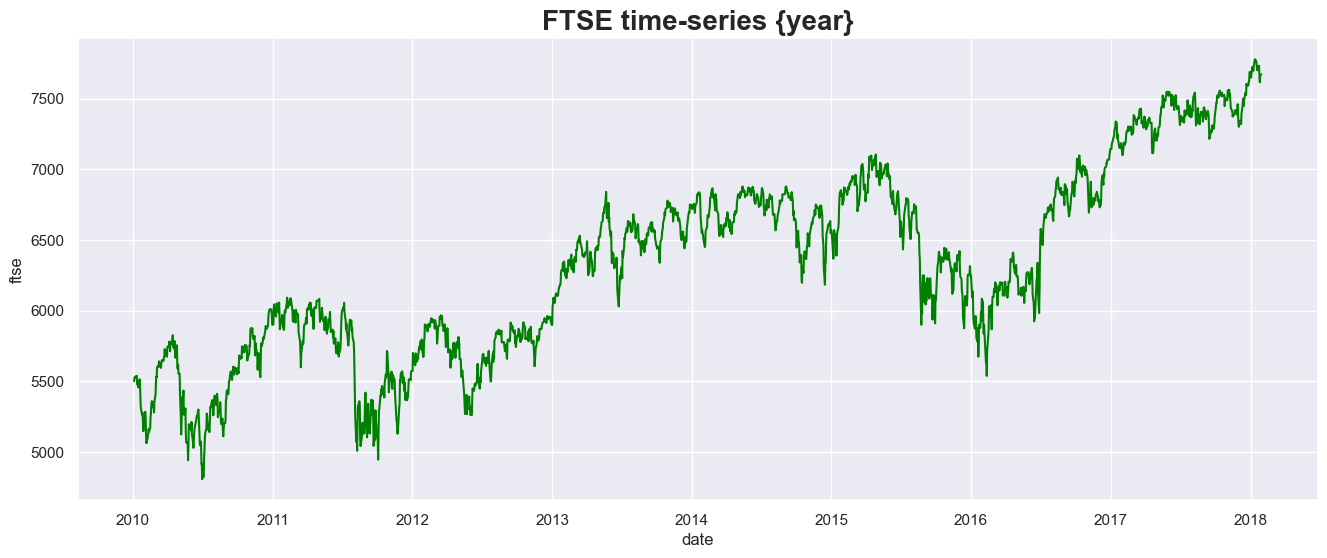

In [14]:
plt.figure(figsize=(16,6))
sns.lineplot(data['ftse'],color='green')
plt.title('FTSE time-series {year}',fontweight='bold',fontsize=20)
plt.show()

## <span style="color: yellow;">Stationarity</span>

In [15]:
# From the graph our series isn't stationary , furthermore we can test it using ADFULLER
adfuller(data['ftse'])

(-1.4603487547641778,
 0.5530271881036313,
 4,
 2101,
 {'1%': -3.43346628154387,
  '5%': -2.8629166417427734,
  '10%': -2.5675028591063254},
 22673.78023934144)

In [16]:
# To fix that ,we use the return instead of the price
return_ftse=data['ftse'].pct_change()*100
return_ftse=return_ftse.iloc[1:]
return_ftse

date
2010-01-05    0.402884
2010-01-06    0.136532
2010-01-07   -0.060036
2010-01-08    0.136066
2010-01-11    0.069206
                ...   
2018-01-23    0.212382
2018-01-24   -1.143311
2018-01-25   -0.360951
2018-01-26    0.652605
2018-01-29    0.078168
Freq: B, Name: ftse, Length: 2105, dtype: float64

In [27]:
# Checking ADFULLER again:
print('ADFULLER Test:',adfuller(return_ftse))

ADFULLER Test: (-24.937539752493787, 0.0, 3, 2101, {'1%': -3.43346628154387, '5%': -2.8629166417427734, '10%': -2.5675028591063254}, 5661.169478400878)


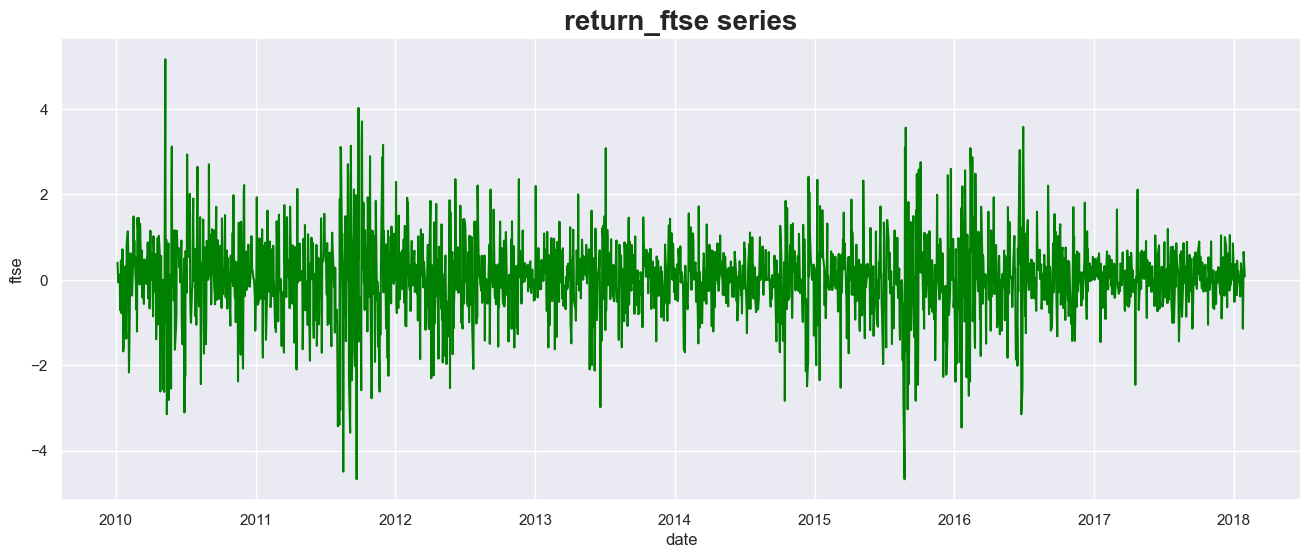

In [18]:
plt.figure(figsize=(16,6))
sns.lineplot(return_ftse,color='green')
plt.title('return_ftse series',fontweight='bold',fontsize=20)
plt.show()

#### <span style="color: green;">AR(+) model</span>


In [19]:
return_models=[]
start=1
max_order=9
for i in range(start,max_order+1):
    ar_model=ARIMA(return_ftse,order=(i,0,0)).fit()
    return_models.append(ar_model)
for j in range(len(return_models)-1):
    print('LLR for model {} and model {} is: {}'.format(j+1,j+2,llr(return_models[j],return_models[j+1])))

LLR for model 1 and model 2 is: 0.074
LLR for model 2 and model 3 is: 0.995
LLR for model 3 and model 4 is: 0.001
LLR for model 4 and model 5 is: 0.386
LLR for model 5 and model 6 is: 0.904
LLR for model 6 and model 7 is: 0.889
LLR for model 7 and model 8 is: 0.011
LLR for model 8 and model 9 is: 0.856


In [25]:
# Both models order (4 & 8) can be good for this series 

#### <span style="color: green;">ACF PACF</span>


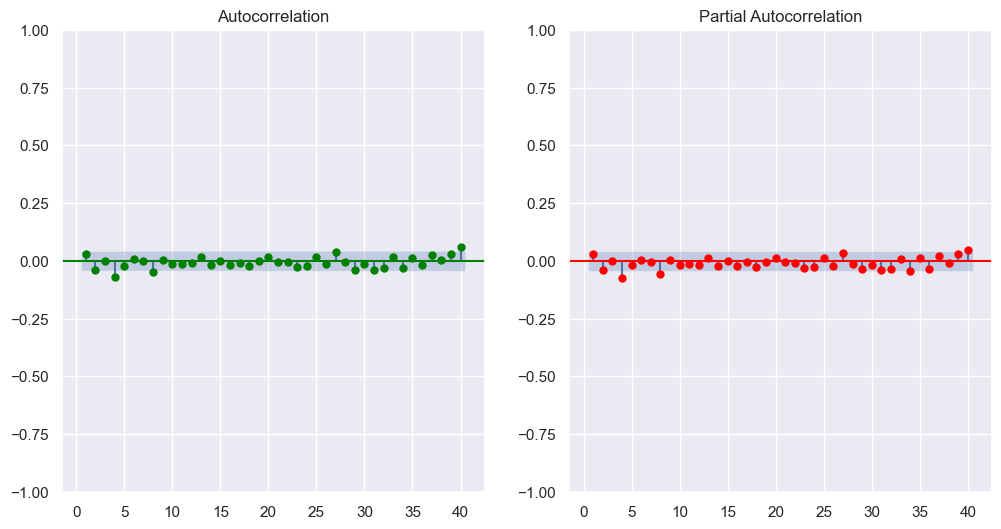

In [24]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
plot_acf(return_ftse,color='green',zero=False,lags=40,ax=ax[0])
plot_pacf(return_ftse,color='red',zero=False,lags=40,method=('ols'),ax=ax[1])
plt.show()